# Same graphs and data - no cleanup
### Imports

In [1]:
from os.path import abspath, join
import pandas as pd
import numpy as np
import re
from mizani.formatters import percent_format
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, ylim,\
    scale_x_continuous, scale_y_continuous, geom_line, geom_boxplot,  xlim, facet_wrap, scale_fill_manual

### Global constants
Files and paths

In [2]:
base_dir = "C:/Nitsan/third/JavaAnalyzer"
analyzer_results_file = "analyzerResults_v2.csv"

Graphs parameters

In [3]:
fill='#5a9cd9'
log_x_scale_labels = ["1", "2-10", "11-100", "101-1000", "1001-10000", "10001-100000"]

Column headers

In [4]:
name_col = "name"
length_col = "length"
project_col = "project"
type_col = "className"
word_count_col = "wordCount"
count_col = "count"
freq_col = "frequency"
rank_col = "rank"

## Data load

In [5]:
df = pd.read_csv(abspath(join(base_dir, analyzer_results_file)))

### Dataframe preview:

In [6]:
print(df.sample(frac=1))

              project        name               className         role  length
375853  Signal-Server       close       MethodDeclaration  DECLARATION       5
130931        Jenkins     RunList    ClassOrInterfaceType    REFERENCE       7
35292            Gson  appendable         FieldAccessExpr    REFERENCE      10
326947        MyBatis           T    ClassOrInterfaceType    REFERENCE       1
150288        Jenkins  getJobName          MethodCallExpr    REFERENCE      10
...               ...         ...                     ...          ...     ...
43824         Hystrix     builder          MethodCallExpr    REFERENCE       7
365041     Playwright         LAX                NameExpr    REFERENCE       3
414455  Signal-Server         get          MethodCallExpr    REFERENCE       3
90029         Jenkins    Solution  ConstructorDeclaration    REFERENCE       8
305855        MyBatis      method         FieldAccessExpr    REFERENCE       6

[436587 rows x 5 columns]


## Histogram of 50 most common words in all projects together:

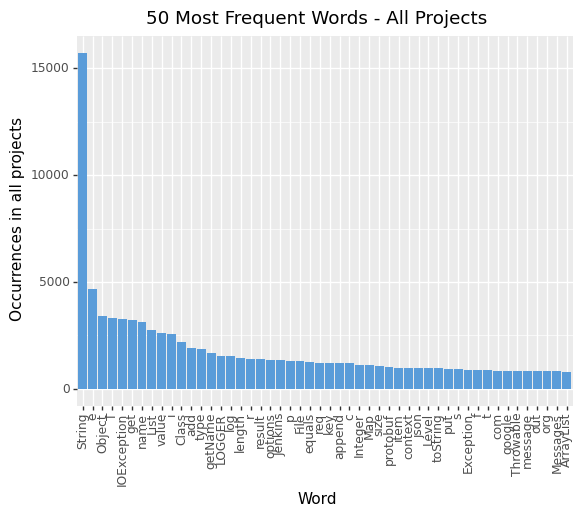

<ggplot: (145112829630)>


In [7]:
n = 50
word_occurrences_df = df.groupby([name_col, length_col])\
    .size()\
    .reset_index(name=count_col)\
    .sort_values(count_col, ascending=False)
word_occurrences_hist_df = word_occurrences_df.nlargest(n, count_col)

print(
	ggplot(word_occurrences_hist_df)
	+ labs(x="Word",
		   y="Occurrences in all projects",
		   title=str(n) + " Most Frequent Words - All Projects")
	+ scale_x_discrete(limits=word_occurrences_hist_df[name_col].tolist())
	+ geom_bar(aes(x=name_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Zipf's Law - Words rank / frequency in log scale:

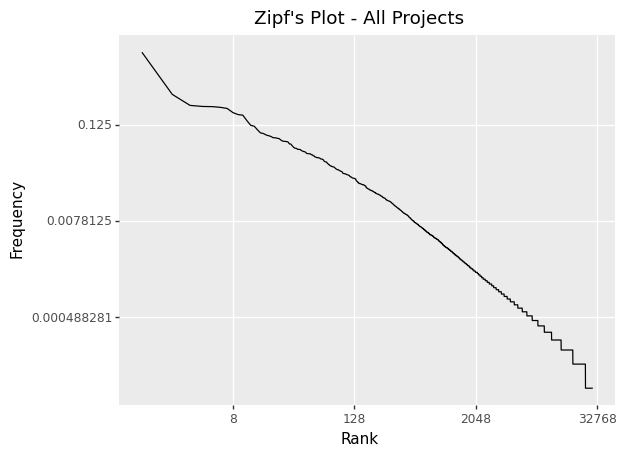

<ggplot: (145112838084)>


In [8]:
most_frequent_word_count = int(word_occurrences_df[:1][count_col])

# Add new normalized "frequency" column
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_count
word_occurrences_df_length = word_occurrences_df.shape[0]
word_occurrences_df[rank_col] = np.linspace(1, word_occurrences_df_length, word_occurrences_df_length)

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


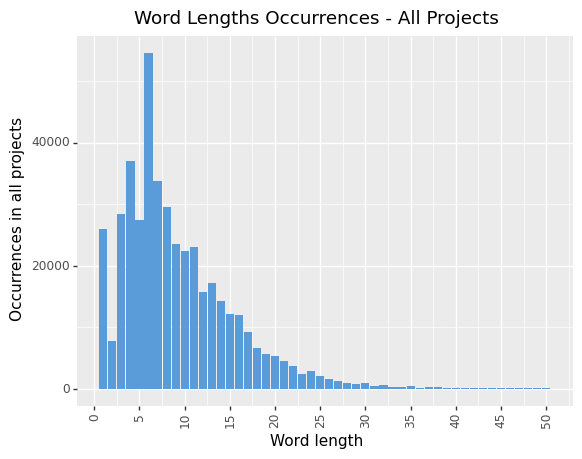

<ggplot: (145112829564)>


In [9]:
n = 50
length_occurrences_df = df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects")
    + scale_x_continuous(breaks=range(0,n+1,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

## Longest word:

In [10]:
print("Length of longest word: " + str(length_occurrences_df[length_col].max()))

Length of longest word: 75


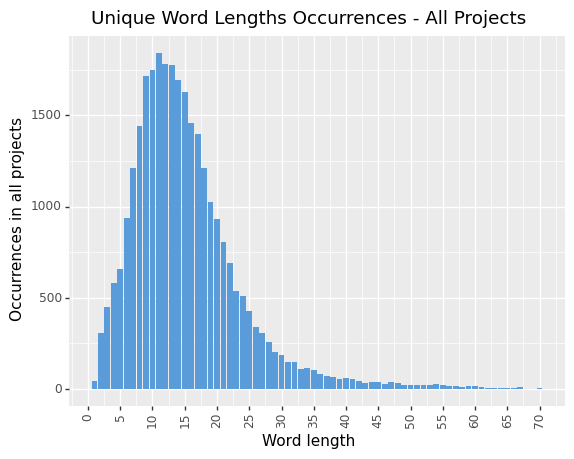

<ggplot: (145113258515)>


In [11]:
n = 70
length_occurrences_df = word_occurrences_df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Unique Word Lengths Occurrences - All Projects")
	+ scale_x_continuous(breaks=range(0,71,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Add words rank per project

In [12]:
word_occurrences_per_project_df = df.groupby([name_col, length_col, project_col])\
    .size() \
    .reset_index(name=count_col) \
    .sort_values(count_col, ascending=False)

# Add rank column per project
# At the end of this process, we will have N rows in our dataframe with rank k,
# where N is the total number of project
projects = []
for project in word_occurrences_per_project_df[project_col].unique():
    project_df = word_occurrences_per_project_df[word_occurrences_per_project_df[project_col] == project]
    project_df.reset_index().sort_values(count_col, ascending=False)
    project_df_size = project_df.shape[0]
    project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)
    projects.append(project_df)

all_projects_df = pd.concat(projects)

# Calculate how many rank bins we'll need, cut the dataframe accordingly
bin_count = int(np.ceil(np.math.log(all_projects_df["project_rank"].max())))
all_projects_df["project_rank_bin"] = pd.cut(all_projects_df["project_rank"],
                                             bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

<ipython-input-12-747aced00e7e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)


## Words' lengths by rank - per project breakdown

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1510 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


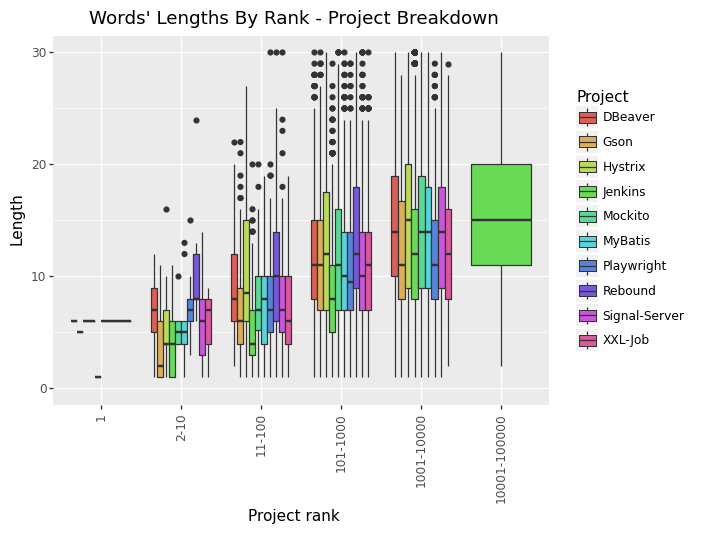

<ggplot: (145113330595)>


In [13]:
print(
    ggplot(all_projects_df)
    + labs(y="Length",
           x="Project rank",
           title="Words' Lengths By Rank - Project Breakdown",
           fill="Project")
    + geom_boxplot(aes(x='project_rank_bin', y=length_col, fill=project_col), position="dodge")
    + ylim(0, 30)
    + scale_x_discrete(limits=all_projects_df["project_rank_bin"].unique(), labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
      )

## Words' lengths by rank - all projects together

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1509 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


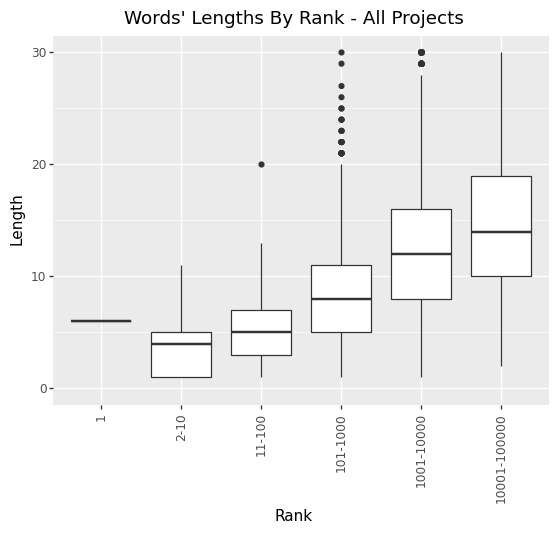

<ggplot: (145113423246)>


In [14]:
bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col], bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

print(ggplot(word_occurrences_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90))
      )

## Compound Words - split and  count
### Define splitting function - by camelCase / PascalCase / snake_case:

In [15]:
def split_identifier_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[A-Z]*(?=[_A-Z]|$))', str(inpt)))

# Make sure the count is correct for different cases:
assert split_identifier_and_count("UUIDa") == 2
assert split_identifier_and_count("_hello") == 1
assert split_identifier_and_count("well_hello") == 2
assert split_identifier_and_count("howDoYouDo") == 4
assert split_identifier_and_count("HowDoYouDo") == 4
assert split_identifier_and_count("okTTYLbye") == 3

### Split all names and add word count column:

In [16]:
word_occurrences_df[word_count_col] = word_occurrences_df[name_col]\
    .apply(split_identifier_and_count)\
    .astype('category')

word_occurrences_per_project_df = word_occurrences_per_project_df.merge(
    word_occurrences_df[[name_col, word_count_col]],
    on=name_col,
    how='left'
)

## Save dataframe as CSV data file:

In [17]:
word_occurrences_df.to_csv(abspath(join(base_dir, "word_occurrences_df_no_cleanup.csv")), index=False)

## Identifiers' lengths frequency with word count breakdown for all project combined:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

  warn(_TPL_DUPLICATE_SCALE.format(ae), PlotnineWarning)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:433: PlotnineWarning: position_stack : Removed 220 rows containing missing values.
  data = self.position.setup_data(self.data, params)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


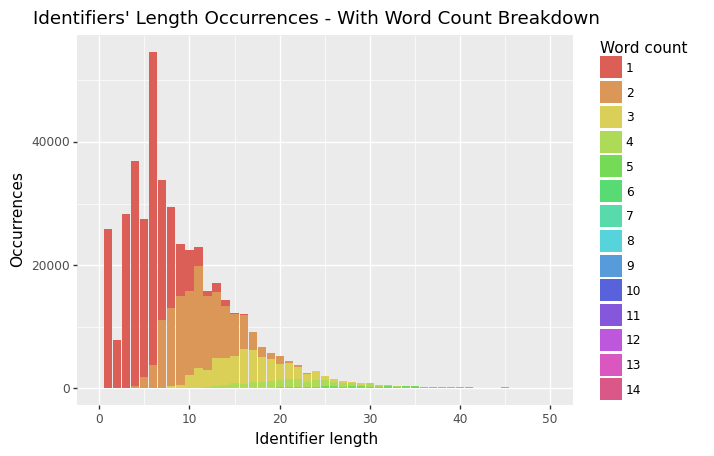

<ggplot: (145113698262)>


In [18]:
n=50
print(
	ggplot(word_occurrences_df)
	+ labs(x="Identifier length",
		   y="Occurrences",
		   title="Identifiers' Length Occurrences - With Word Count Breakdown",
           fill="Word count")
    + geom_bar(aes(x=length_col, y=count_col, fill=word_count_col), stat='identity')
    + scale_x_continuous(breaks=range(0,n+1,5))
    + xlim((0, n))
)

## Identifiers lengths frequency, with word count breakdown - per project:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:433: PlotnineWarning: position_stack : Removed 895 rows containing missing values.
  data = self.position.setup_data(self.data, params)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 100 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


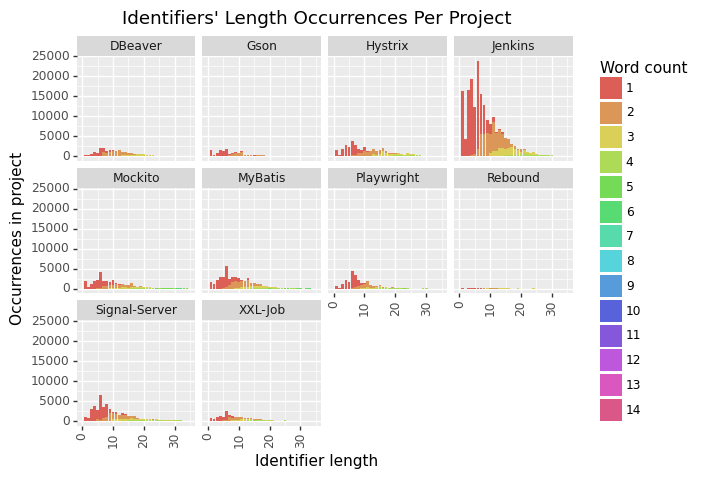

<ggplot: (145113697702)>


In [19]:
print(
	ggplot(word_occurrences_per_project_df)
	+ labs(x="Identifier length",
		   y="Occurrences in project",
		   title="Identifiers' Length Occurrences Per Project",
           fill="Word count")
    + geom_bar(aes(x=length_col, y=count_col, fill=word_count_col), stat='identity')
  	+ xlim(0, 35)
	+ facet_wrap(project_col)
	+ theme(axis_text_x=element_text(rotation=90))
)



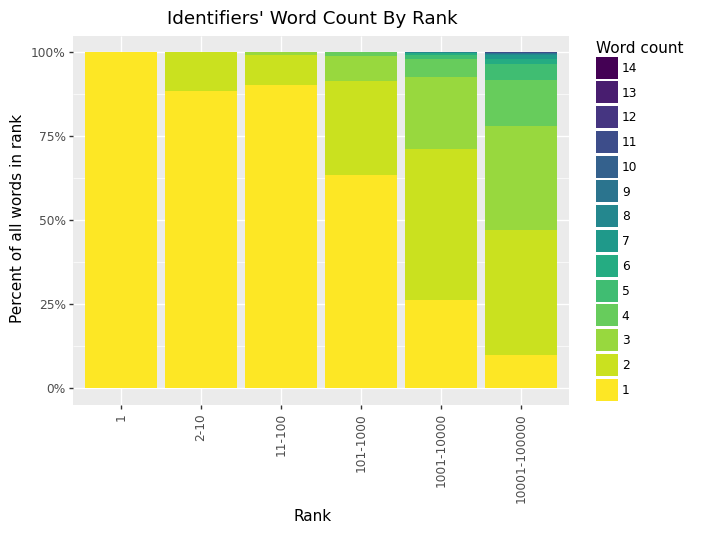

<ggplot: (145113424960)>


In [20]:
word_occurrences_df[word_count_col] = pd.Categorical(word_occurrences_df[word_count_col],
                                             categories=list(range(14, 0, -1)),
                                             ordered=True)

most_frequent_word_occurrences = int(word_occurrences_df[:1][count_col])
data_length = word_occurrences_df.shape[0]
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_occurrences
word_occurrences_df[rank_col] = np.linspace(1, data_length, data_length)

bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col],
									bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="Identifiers' Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', y=count_col, fill=word_count_col), stat='identity', position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
)

# Regenerating all the graphs after splitting compound words
## Setup splitting function:

In [37]:
word_occurrences_df_for_split = word_occurrences_df.reset_index(drop=True)

def getIndex(df, inpt):
    return df.index[df[name_col] == inpt].tolist()[0]

split_words_count = np.zeros(word_occurrences_df_for_split.shape[0])
def split_identifier_and_append_to_df(inpt):
    if inpt is None:
        return 0
    parts = re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[A-Z]*(?=[_A-Z]|$))', str(inpt))
    if len(parts) > 1:
        split_words_count[getIndex(word_occurrences_df_for_split, inpt)] += 1
        for part in parts:
            plain_part = part.lower().replace("_", "")
            if plain_part in split_words:
                split_words[plain_part] += 1
            else:
                split_words[plain_part] = 1
    else:
        stripped_form = inpt.lower().replace("_", "")
        if stripped_form != inpt:
            split_words_count[getIndex(word_occurrences_df_for_split, inpt)] += 1
            if stripped_form in split_words:
                split_words[stripped_form] += 1
            else:
                split_words[stripped_form] = 1

split_words = {}
word_occurrences_df_for_split[name_col].apply(split_identifier_and_append_to_df)
split_words_df = pd.DataFrame(split_words.items(), columns=[name_col, count_col])

Words + count that will be added to original data:

In [38]:
print(split_words_df)

              name  count
0           string    229
1           object    223
2                t     20
3               io     25
4        exception    390
...            ...    ...
4487        value4      1
4488       lanuage      1
4489  intersection      1
4490          boxs      1
4491     databases      1

[4492 rows x 2 columns]


In [40]:
word_occurrences_df_for_split[name_col] = word_occurrences_df_for_split[name_col].str.lower()
word_occurrences_df_for_split = word_occurrences_df_for_split[split_words_count == 0]
word_occurrences_df_for_split = word_occurrences_df_for_split[word_occurrences_df_for_split[count_col] > 0]
split_words_df[length_col] = split_words_df[name_col].str.len()
split_words_df = pd.concat([word_occurrences_df_for_split, split_words_df]).groupby([name_col, length_col])[count_col]\
    .sum()\
    .reset_index()\
    .sort_values(count_col, ascending=False)

ValueError: Item wrong length 29601 instead of 2824.

Data after adding split words:

In [41]:
print(split_words_df)

           name  length  count
1963        get       3   6634
1484          e       1   4676
2998       name       4   3923
5082      value       5   2930
2163          i       1   2685
...         ...     ...    ...
2824     maven1       6      1
2822     matrix       6      1
2820       math       4      1
2814  matchable       9      1
5329     zscore       6      1

[5330 rows x 3 columns]


### Words frequencies - Zipf's plot:

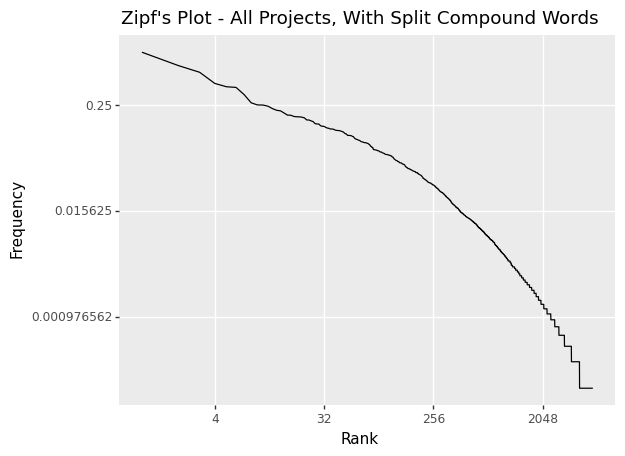

<ggplot: (145120464020)>


In [42]:
split_words_df[freq_col] = split_words_df[count_col] / int(split_words_df[:1][count_col])
split_words_df_length = split_words_df.shape[0]
split_words_df[rank_col] = np.linspace(1, split_words_df_length, split_words_df_length)

print(
    ggplot(split_words_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects, With Split Compound Words")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


### Words lengths occurrences:

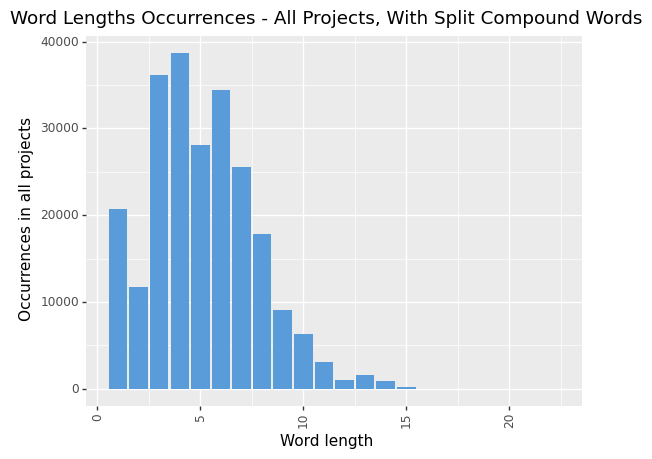

<ggplot: (145113243618)>


In [43]:
split_words_df = split_words_df[split_words_df[length_col] != 0]

n = 50
length_occurrences_hist_df_with_split_words = split_words_df.groupby(length_col)[count_col]\
    .sum()\
    .reset_index()\
    .nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df_with_split_words)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects, With Split Compound Words")
    + scale_x_continuous(breaks=range(0,n+1,5))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Words' lengths by rank - all projects together:

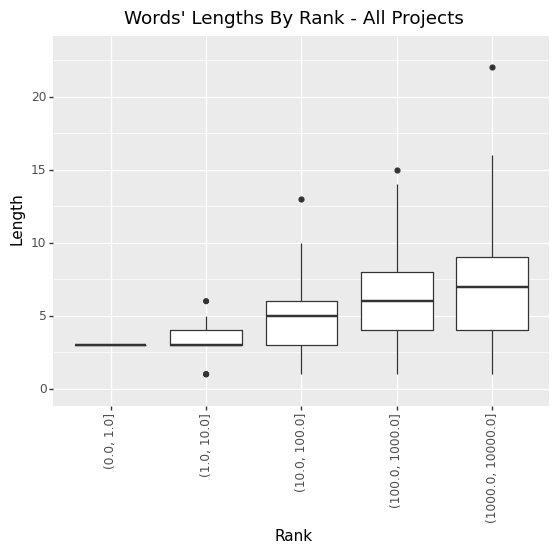

<ggplot: (145121920829)>


In [44]:
split_bin_count = int(np.ceil(np.math.log(split_words_df.shape[0])))
split_words_df["rank_bin"] = pd.cut(split_words_df[rank_col],
                                         bins=[0]+list(np.logspace(0, split_bin_count, split_bin_count+1)))

print(ggplot(split_words_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 23)
      + theme(axis_text_x=element_text(rotation=90))
      )

## Save dataframe as CSV data file:

In [45]:
split_words_df.to_csv(abspath(join(base_dir, "word_occurrences_df_no_cleanup_with_split_words.csv")),
                           index=False)